In [302]:
from pathlib import Path
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, LineString , Polygon, mapping, shape

import csv
from pathlib import Path

import rasterio
import rasterio.mask
from rasterio.plot import show_hist
from rasterio.plot import show

import rasterstats
from rasterstats import zonal_stats

from descartes import PolygonPatch

import geojson

from fiona import collection
import fiona

import geoplot 

from shape_generator import select_raster_file

In [155]:
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import ListedColormap

## Setting up the data files

In [64]:
# reading in the cyclone data
data_folder = Path.cwd().parent.parent.joinpath('datasets') 
#print(data_folder)
#input_filename = 'epac-atl.csv'
#input_filename = 'ibtrax.csv'
input_filename = 'ibtrax_.csv'
#input_filename = 'missing (1).csv'
input_file = Path(data_folder).joinpath(input_filename)
print(input_file)

G:\Omdena\wfpdisrel\#task1-datacollection\datasets\ibtrax_.csv


In [65]:
# reading in the Gridded Population of the World dataset
data_folder = Path.cwd().parent.parent.joinpath('datasets', 'Gridded Population of the World (GPW)')
#print(data_folder)
input_filename = 'gpw-v4-population-count-adjusted-to-2015-unwpp-country-totals_2015.tif'
input_raster_file = Path(data_folder).joinpath(input_filename)
print(input_raster_file)

G:\Omdena\wfpdisrel\#task1-datacollection\datasets\Gridded Population of the World (GPW)\gpw-v4-population-count-adjusted-to-2015-unwpp-country-totals_2015.tif


In [66]:
# get the countries associated for the geometry boundary's
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


In [67]:
df_input = pd.read_csv(input_file)  

In [68]:
df_input.columns

Index(['Unnamed: 0', 'SID', 'NAME', 'SEASON', 'LON', 'LAT', 'max_34', 'max_50',
       'max_64', 'SID_1', 'SID_2', 'max_34_1', 'max_50_1', 'max_64_1'],
      dtype='object')

In [69]:
#df_input.rename(columns = {'NAME':'name', 'SEASON': 'year', 'LON': 'long', 'LAT':'lat'}, inplace = True) 
#df_input.columns

## Create list of cyclones by name and year

In [70]:
cyclones = df_input.groupby(['SID', 'NAME', 'SEASON'], as_index = False).sum()
cyclones = cyclones[['SID','NAME', 'SEASON']]
cyclones

,SID,NAME,SEASON
0,1949163N07145,DELLA,1949
1,1950241N23140,JANE,1950
2,1951224N12316,CHARLIE,1951
3,1951337N09150,AMY,1951
4,1952180N05144,EMMA,1952
...,...,...,...
795,2018349N10085,PHETHAI,2018
796,2018365N09113,PABUK,2018
797,2019068S17040,IDAI,2019
798,2019113S10051,KENNETH,2019


In [71]:
i = 0
this_name = cyclone_name = (cyclones.iloc[i]['NAME'])
this_name

'DELLA'

### Helper function for getting cyclone year and name by SID

In [72]:
def get_cyclone_name_year_by_SID(SID):
    cyc_name = cyclones.loc[cyclones.SID == SID].NAME.values[0]
    cyc_year = cyclones.loc[cyclones.SID == SID].SEASON.values[0]
    return cyc_name, cyc_year    

In [73]:
#cyclone_name = 'IVAN'
#cyclone_year = 2004
SID = '2018365N09113'

In [74]:
cyclone_name, cyclone_year = get_cyclone_name_year_by_SID(SID)
print (cyclone_name, cyclone_year)

PABUK 2018


## Population extraction for a single cyclone - step by step

In [75]:
windspeeds = ['max_34','max_50', 'max_64']
windspeed = 'max_50'

### Create a dataset for a single cyclone

In [76]:
cyclone_df = df_input[(df_input.SID == SID)].copy()
cyclone_df

,Unnamed: 0,SID,NAME,SEASON,LON,LAT,max_34,max_50,max_64,SID_1,SID_2,max_34_1,max_50_1,max_64_1
62814,462883,2018365N09113,PABUK,2018,112.60,8.50,115.0,40.0,15.0,2018365N09113,2018365N09113,115.0,40.0,15.0
62815,462884,2018365N09113,PABUK,2018,111.78,8.16,115.0,40.0,15.0,2018365N09113,2018365N09113,115.0,40.0,15.0
62816,462885,2018365N09113,PABUK,2018,111.20,7.70,115.0,40.0,15.0,2018365N09113,2018365N09113,115.0,40.0,15.0
62817,462886,2018365N09113,PABUK,2018,111.01,7.09,115.0,40.0,15.0,2018365N09113,2018365N09113,115.0,40.0,15.0
62818,462887,2018365N09113,PABUK,2018,111.00,6.60,115.0,40.0,15.0,2018365N09113,2018365N09113,115.0,40.0,15.0
62819,462888,2018365N09113,PABUK,2018,110.93,6.59,115.0,40.0,15.0,2018365N09113,2018365N09113,115.0,40.0,15.0
62820,462889,2018365N09113,PABUK,2018,110.80,6.60,115.0,40.0,15.0,2018365N09113,2018365N09113,115.0,40.0,15.0
62821,462890,2018365N09113,PABUK,2018,110.56,6.37,115.0,40.0,15.0,2018365N09113,2018365N09113,115.0,40.0,15.0
62822,462891,2018365N09113,PABUK,2018,110.30,6.10,115.0,40.0,15.0,2018365N09113,2018365N09113,115.0,40.0,15.0
62823,462892,2018365N09113,PABUK,2018,110.12,5.95,115.0,40.0,15.0,2018365N09113,2018365N09113,115.0,40.0,15.0


In [77]:
def create_shifted_dataset(df):
    my_cyclone = df[['SID', 'NAME','SEASON','LAT','LON', 'max_34', 'max_50', 'max_64']].copy()
    my_cyclone['LAT_1']= my_cyclone['LAT'].shift(-1)
    my_cyclone['LON_1']= my_cyclone['LON'].shift(-1)
    my_cyclone = my_cyclone.dropna()
    return my_cyclone

In [78]:
single_cyclone_df= create_shifted_dataset(cyclone_df)
single_cyclone_df

,SID,NAME,SEASON,LAT,LON,max_34,max_50,max_64,LAT_1,LON_1
62814,2018365N09113,PABUK,2018,8.50,112.60,115.0,40.0,15.0,8.16,111.78
62815,2018365N09113,PABUK,2018,8.16,111.78,115.0,40.0,15.0,7.70,111.20
62816,2018365N09113,PABUK,2018,7.70,111.20,115.0,40.0,15.0,7.09,111.01
62817,2018365N09113,PABUK,2018,7.09,111.01,115.0,40.0,15.0,6.60,111.00
62818,2018365N09113,PABUK,2018,6.60,111.00,115.0,40.0,15.0,6.59,110.93
62819,2018365N09113,PABUK,2018,6.59,110.93,115.0,40.0,15.0,6.60,110.80
62820,2018365N09113,PABUK,2018,6.60,110.80,115.0,40.0,15.0,6.37,110.56
62821,2018365N09113,PABUK,2018,6.37,110.56,115.0,40.0,15.0,6.10,110.30
62822,2018365N09113,PABUK,2018,6.10,110.30,115.0,40.0,15.0,5.95,110.12
62823,2018365N09113,PABUK,2018,5.95,110.12,115.0,40.0,15.0,5.90,109.90


In [79]:
def create_cyclone_gdf(df):
    df['point_0'] = df.apply(lambda row: Point(row.LON, row.LAT), axis=1)
    gdf = gpd.GeoDataFrame(df, geometry='point_0') #, crs={'init': 'epsg:4326'})  # deprecated version
    gdf.crs =  "EPSG:4326"
    gdf['point_1']  = gdf.apply(lambda row: Point(row.LON_1, row.LAT_1), axis=1)
    gdf['line']  = gdf.apply(lambda row: LineString((row["point_0"], row["point_1"])), axis=1)
    return gdf

### Create GeoPandasDataFrame for single cyclone

In [80]:
cyclone_gdf = create_cyclone_gdf(single_cyclone_df)
cyclone_gdf

,SID,NAME,SEASON,LAT,LON,max_34,max_50,max_64,LAT_1,LON_1,point_0,point_1,line
62814,2018365N09113,PABUK,2018,8.50,112.60,115.0,40.0,15.0,8.16,111.78,POINT (112.60000 8.50000),POINT (111.78 8.16),"LINESTRING (112.6 8.5, 111.78 8.16)"
62815,2018365N09113,PABUK,2018,8.16,111.78,115.0,40.0,15.0,7.70,111.20,POINT (111.78000 8.16000),POINT (111.2 7.7),"LINESTRING (111.78 8.16, 111.2 7.7)"
62816,2018365N09113,PABUK,2018,7.70,111.20,115.0,40.0,15.0,7.09,111.01,POINT (111.20000 7.70000),POINT (111.01 7.09),"LINESTRING (111.2 7.7, 111.01 7.09)"
62817,2018365N09113,PABUK,2018,7.09,111.01,115.0,40.0,15.0,6.60,111.00,POINT (111.01000 7.09000),POINT (111 6.6),"LINESTRING (111.01 7.09, 111 6.6)"
62818,2018365N09113,PABUK,2018,6.60,111.00,115.0,40.0,15.0,6.59,110.93,POINT (111.00000 6.60000),POINT (110.93 6.59),"LINESTRING (111 6.6, 110.93 6.59)"
62819,2018365N09113,PABUK,2018,6.59,110.93,115.0,40.0,15.0,6.60,110.80,POINT (110.93000 6.59000),POINT (110.8 6.6),"LINESTRING (110.93 6.59, 110.8 6.6)"
62820,2018365N09113,PABUK,2018,6.60,110.80,115.0,40.0,15.0,6.37,110.56,POINT (110.80000 6.60000),POINT (110.56 6.37),"LINESTRING (110.8 6.6, 110.56 6.37)"
62821,2018365N09113,PABUK,2018,6.37,110.56,115.0,40.0,15.0,6.10,110.30,POINT (110.56000 6.37000),POINT (110.3 6.1),"LINESTRING (110.56 6.37, 110.3 6.1)"
62822,2018365N09113,PABUK,2018,6.10,110.30,115.0,40.0,15.0,5.95,110.12,POINT (110.30000 6.10000),POINT (110.12 5.95),"LINESTRING (110.3 6.1, 110.12 5.95)"
62823,2018365N09113,PABUK,2018,5.95,110.12,115.0,40.0,15.0,5.90,109.90,POINT (110.12000 5.95000),POINT (109.9 5.9),"LINESTRING (110.12 5.95, 109.9 5.9)"


### Create a buffer of the GeoPandasDataFrame according to the radii of the given windspeed

In [81]:
def bufer_max_output(df,wind_speed):
    df = df.set_geometry('point_0')
    df = df.to_crs('epsg:3395')
    buffer_fact = 1825          # dimensions are in nautic miles, buffering is done in meters
    df['buf_center_{}'.format(wind_speed)] = df.apply(lambda x: x.point_0.buffer(x[wind_speed] * buffer_fact) , axis=1)
    df = df.set_geometry('buf_center_{}'.format(wind_speed))
    df = df.to_crs('epsg:4326')
    df = df.set_geometry('line')
    df = df.to_crs('epsg:3395')
    df['buf_line_{}'.format(wind_speed)] = df.apply(lambda x: x.line.buffer(x[wind_speed] * buffer_fact) , axis=1)
    df = df.set_geometry('buf_line_{}'.format(wind_speed))
    df = df.to_crs('epsg:4326')
    df = gpd.GeoDataFrame(df, geometry='buf_line_{}'.format(wind_speed))
    df.crs = 'epsg:4326'                      
    return df

### Create the outline of the shape for the given windspeed

In [110]:
def create_buffered_shape(buffer_gdf, wind_speed):
    # requires buffer_gdf that was buffered to the according windspeed!
    buffer_gdf.set_geometry('buf_center_{}'.format(wind_speed), inplace=True)
    center_shape = buffer_gdf['buf_center_{}'.format(wind_speed)].unary_union
    buffer_gdf.set_geometry('buf_line_{}'.format(wind_speed), inplace=True)
    line_shape = buffer_gdf['buf_line_{}'.format(wind_speed)].unary_union
    outline = line_shape.union(center_shape)  # combine buffered center and buffered line
    shape_gdf = GeoDataFrame( geometry = [outline])
    shape_gdf.crs = 'epsg:4326'      
    return shape_gdf

In [111]:
buffer_gdf = bufer_max_output(cyclone_gdf,'max_34')
buffer_gdf.tail()

,SID,NAME,SEASON,LAT,LON,max_34,max_50,max_64,LAT_1,LON_1,point_0,point_1,line,buf_center_max_34,buf_line_max_34
62862,2018365N09113,PABUK,2018,10.90,93.40,63.0,40.0,15.0,10.97,92.73,POINT (10397240.440 1212693.837),POINT (92.73 10.97),"LINESTRING (10397240.440 1212693.837, 10322656...","POLYGON ((94.43284 10.90000, 94.42786 10.79993...","POLYGON ((92.62141 9.95339, 92.52126 9.96885, ..."
62863,2018365N09113,PABUK,2018,10.97,92.73,63.0,40.0,15.0,11.10,92.20,POINT (10322656.381 1220579.074),POINT (92.2 11.1),"LINESTRING (10322656.381 1220579.074, 10263657...","POLYGON ((93.76284 10.97000, 93.75786 10.86995...","POLYGON ((91.95111 10.10832, 91.85406 10.13727..."
62864,2018365N09113,PABUK,2018,11.10,92.20,63.0,40.0,15.0,11.28,91.74,POINT (10263657.051 1235228.114),POINT (91.73999999999999 11.28),"LINESTRING (10263657.051 1235228.114, 10212450...","POLYGON ((93.23284 11.10000, 93.22786 11.00000...","POLYGON ((91.35946 10.33072, 91.26718 10.37223..."
62865,2018365N09113,PABUK,2018,11.28,91.74,63.0,40.0,15.0,11.50,91.30,POINT (10212450.085 1255522.324),POINT (91.3 11.5),"LINESTRING (10212450.085 1255522.324, 10163469...","POLYGON ((92.77284 11.28000, 92.76786 11.18006...","POLYGON ((90.83312 10.58991, 90.74507 10.63957..."
62866,2018365N09113,PABUK,2018,11.50,91.30,63.0,40.0,15.0,11.75,90.78,POINT (10163469.509 1280343.879),POINT (90.78 11.75),"LINESTRING (10163469.509 1280343.879, 10105583...","POLYGON ((92.33284 11.50000, 92.32786 11.40014...","POLYGON ((90.32727 10.83375, 90.23846 10.88204..."


In [424]:
max_34_gdf = bufer_max_output(cyclone_gdf,'max_34')
max_34_shape = create_buffered_shape(max_34_gdf, 'max_34')
max_34_shape
#max_34_shape.crs

,geometry
0,"POLYGON ((111.64966 4.78152, 111.64240 4.77337..."


In [113]:
max_50_gdf = bufer_max_output(cyclone_gdf,'max_50')
max_50_shape = create_buffered_shape(max_50_gdf, 'max_50')
max_50_shape

,geometry
0,"POLYGON ((108.32792 5.16584, 108.32683 5.16600..."


In [114]:
max_64_gdf = bufer_max_output(cyclone_gdf,'max_64')
max_64_shape = create_buffered_shape(max_64_gdf, 'max_64')
max_64_shape

,geometry
0,"POLYGON ((108.36672 5.57477, 108.36631 5.57483..."


### Some helper functions for plotting

In [373]:
from shapely.geometry import Polygon

In [468]:
mng = plt.get_current_fig_manager()

<Figure size 432x288 with 0 Axes>

In [324]:
# defining colors for the plots
country_general="#cccccc"
country_borders = 'dimgray'
max_34_fill = 'gold'
max_50_fill = 'orange'
max_64_fill = 'red'
alpha = 0.6
country_1_fill = 'blue'
country_alpha = 0.35
marker_color = 'red'
linewidth= 0.5

In [264]:
#sorted(world['name'])

In [471]:
def plot_cyclone_on_worldmap(gdf):
    sns.set_style('darkgrid')
    sns.set_context('notebook')
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world = world[(world['name'] != 'Antarctica')]
    
    fig, ax = plt.subplots()
    world.plot(ax=ax, color=country_general, edgecolor = country_borders)
    gdf.plot(ax=ax, markersize=1, color=marker_color)

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

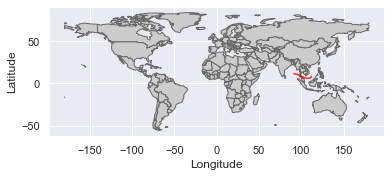

In [472]:
plot_cyclone_on_worldmap(cyclone_gdf)

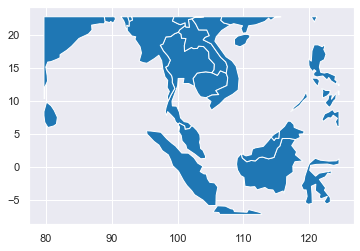

In [495]:
gdf = gdf1
buffer = 10
def create_buffered_polygon(gdf, buffer):
    xmin, ymin, xmax, ymax = gdf.total_bounds
    #type(xmin)
    polygon = Polygon([(xmin-buffer, ymin-buffer),(xmin-buffer, ymax+buffer), 
                       (xmax+buffer, ymax+buffer), (xmax+ buffer,ymin-buffer)])    # defines all four corners of the rectangle
    poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=world.crs)
    return poly_gdf
clip_gdf = create_buffered_polygon(gdf, buffer)
partial_world = gpd.clip(world, clip_gdf)
partial_world.plot()

In [496]:
def plot_cyclone_on_partial_worldmap(gdf):    
    sns.set_style('darkgrid')
    sns.set_context('notebook')
    
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
     
    clip_gdf = create_buffered_polygon(gdf, buffer)
    partial_world = gpd.clip(world, clip_gdf)
    
    fig, ax = plt.subplots()
    #fig, ax = plt.subplots(figsize=(10, 10))
    partial_world.plot(ax=ax, color=country_general, edgecolor = country_borders)
    #world.plot(ax=ax, color=country_general, edgecolor = country_borders)
    gdf.plot(ax=ax, markersize=1, color="#cc0000")
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    ax.set_title(f"Cyclone {cyclone_name} - {cyclone_year}", fontsize=15)
    plt.show()

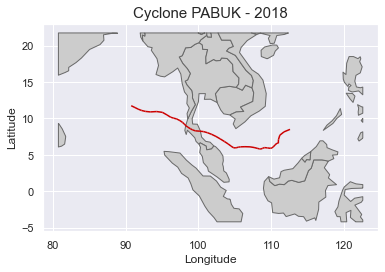

In [497]:
plot_cyclone_on_partial_worldmap(cyclone_gdf)

In [498]:
def plot_cyclone_centroids_on_partial_worldmap(gdf):
    
    sns.set_style('darkgrid')
    sns.set_context('notebook')
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    
    clip_gdf = create_buffered_polygon(gdf, buffer)
    partial_world = gpd.clip(world, clip_gdf)
    
    #Set geometry column to line
    gdf.set_geometry('point_0', inplace=True)
 
    fig, ax = plt.subplots()

    partial_world.plot(ax=ax, color=country_general, edgecolor = country_borders)
    gdf.plot(ax=ax, markersize=1, color=marker_color, label= 'max_pop')
    #ax.legend(frameon=False)
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    ax.set_title(f"Cyclone {cyclone_name} - {cyclone_year}", fontsize=15)
    plt.show()

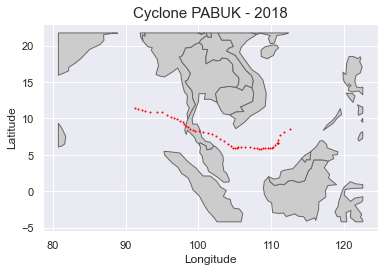

In [499]:
plot_cyclone_centroids_on_partial_worldmap(cyclone_gdf)

In [500]:
def plot_cyclone_path_on_partial_worldmap(gdf):
    
    sns.set_style('darkgrid')
    sns.set_context('notebook')
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    
    clip_gdf = create_buffered_polygon(gdf, buffer)
    partial_world = gpd.clip(world, clip_gdf)

    #Set geometry column to line
    gdf.set_geometry('line', inplace=True)

    fig, ax = plt.subplots()

    partial_world.plot(ax=ax, color=country_general, edgecolor = country_borders)
    gdf.plot(ax=ax, markersize=1, color=marker_color, label= 'max_pop')
    #ax.legend(frameon=False)
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    ax.set_title(f"Cyclone {cyclone_name} - {cyclone_year}", fontsize=15)
    plt.show()

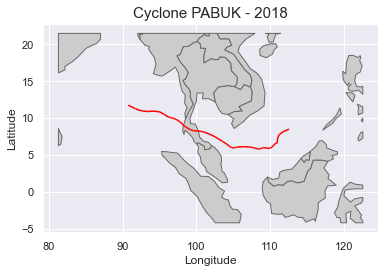

In [501]:
plot_cyclone_path_on_partial_worldmap(cyclone_gdf)

In [503]:
def plot_cyclone_buffer_on_partial_worldmap(gdf1, windspeed):
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    
    # defininig the boundaries of the plot
    clip_gdf = create_buffered_polygon(gdf, buffer)
    partial_world = gpd.clip(world, clip_gdf)
 
    #fig, ax = plt.subplots(figsize=(10, 5))
    fig, ax = plt.subplots()
    partial_world.plot(ax=ax, color=country_general, edgecolor = country_borders, linewidth = linewidth)
    gdf1.plot(ax=ax, markersize=1, color=max_34_fill, alpha=alpha, legend=True, label=windspeed)
    #gdf2.plot(ax=ax, markersize=1, color=max_50_fill, alpha=alpha, label='max_50kn')
    #gdf3.plot(ax=ax, markersize=1, color=max_64_fill, alpha=alpha, label='max_64kn')
    
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    ax.set_title(f"Cyclone {cyclone_name} - {cyclone_year}", fontsize=15)
    #ax.legend(frameon=False)
    plt.show()

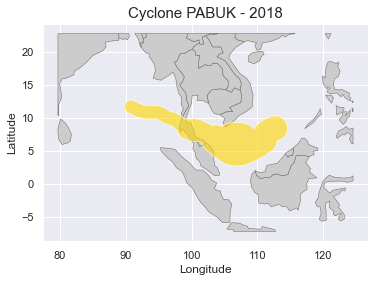

In [504]:
plot_cyclone_buffer_on_partial_worldmap(max_34_shape, 'max_34')

In [301]:
cyclone_gdf.head()

,SID,NAME,SEASON,LAT,LON,max_34,max_50,max_64,LAT_1,LON_1,point_0,point_1,line
62814,2018365N09113,PABUK,2018,8.50,112.60,115.0,40.0,15.0,8.16,111.78,POINT (112.60000 8.50000),POINT (111.78 8.16),"LINESTRING (112.6 8.5, 111.78 8.16)"
62815,2018365N09113,PABUK,2018,8.16,111.78,115.0,40.0,15.0,7.70,111.20,POINT (111.78000 8.16000),POINT (111.2 7.7),"LINESTRING (111.78 8.16, 111.2 7.7)"
62816,2018365N09113,PABUK,2018,7.70,111.20,115.0,40.0,15.0,7.09,111.01,POINT (111.20000 7.70000),POINT (111.01 7.09),"LINESTRING (111.2 7.7, 111.01 7.09)"
62817,2018365N09113,PABUK,2018,7.09,111.01,115.0,40.0,15.0,6.60,111.00,POINT (111.01000 7.09000),POINT (111 6.6),"LINESTRING (111.01 7.09, 111 6.6)"
62818,2018365N09113,PABUK,2018,6.60,111.00,115.0,40.0,15.0,6.59,110.93,POINT (111.00000 6.60000),POINT (110.93 6.59),"LINESTRING (111 6.6, 110.93 6.59)"


In [232]:
def plotCountryPatch(ax, country_name, fcolor):
    # plot a country on the provided axes
    country = world[world.name == country_name]
    country_data = country.__geo_interface__['features']  # geopandas's geo_interface
    country_geometry = {'type': country_data[0]['geometry']['type'], \
              'coordinates': country_data[0]['geometry']['coordinates']}
    ax.add_patch(PolygonPatch( country_geometry, label = country_name,fc=fcolor, ec="black", alpha=country_alpha, zorder=2 ))
    #ax.add_patch(PolygonPatch( country_geometry, label = country_name, cmap='Pastel1', ec="black", alpha=alpha, zorder=2 ))

In [564]:
def plot_cyclone_on_partial_worldmap3(gdf1,gdf2,gdf3):
    sns.set_style(style='white')
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    
    # defininig the boundaries of the plot
    gdf = gpd.GeoDataFrame(pd.concat([gdf1, gdf2, gdf3]))
    
    clip_gdf = create_buffered_polygon(gdf, buffer)
    partial_world = gpd.clip(world, clip_gdf)
 
    #fig, ax = plt.subplots(figsize=(10, 5))
    fig, ax = plt.subplots()
    partial_world.plot(ax=ax, color=country_general, edgecolor = country_borders, linewidth=linewidth)
    gdf1.plot(ax=ax, markersize=1, color=max_34_fill, alpha=alpha, legend=True, label='max_34kn')
    gdf2.plot(ax=ax, markersize=1, color=max_50_fill, alpha=alpha, label='max_50kn')
    gdf3.plot(ax=ax, markersize=1, color=max_64_fill, alpha=alpha, label='max_64kn')
    
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    ax.set_title(f"Cyclone {cyclone_name} - {cyclone_year}", fontsize=15)
    #ax.legend(frameon=False)
    plt.show()

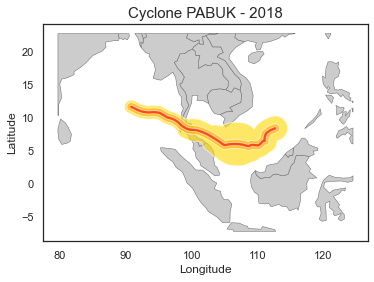

In [565]:
plot_cyclone_on_partial_worldmap3(max_34_shape,gdf2,gdf3)

In [234]:
def get_countries(affected_countries):
    countries = []
    for i in range (len(affected_countries)):
            #cyclone = {}
            country = affected_countries.iloc[i]['name']
            countries.append(country)

    countries = list(set(countries))
    #print (countries)
    return countries

In [236]:
max_34_countries = get_countries(gpd.overlay(world, max_34_shape, how='intersection'))
max_50_countries = get_countries(gpd.overlay(world, max_50_shape, how='intersection'))
max_64_countries = get_countries(gpd.overlay(world, max_64_shape, how='intersection'))


In [419]:
affected_countries_34 = gpd.overlay(world, max_34_shape, how='intersection')
affected_countries_50 = gpd.overlay(world, max_50_shape, how='intersection')
affected_countries_64 = gpd.overlay(world, max_64_shape, how='intersection')
affected_countries = affected_countries_34 # because max_34 is the maximal extent of the cyclone
affected_countries.crs = 'epsg:4326'
type(affected_countries_34)

geopandas.geodataframe.GeoDataFrame

In [559]:
def plot_cyclone_on_partial_worldmap4(gdf1,gdf2,gdf3):
    sns.set_style('darkgrid')
    sns.set_context('notebook')
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    
    max_34_countries = get_countries(gpd.overlay(world, gdf1, how='intersection'))
    max_50_countries = get_countries(gpd.overlay(world, gdf2, how='intersection'))
    max_64_countries = get_countries(gpd.overlay(world, gdf3, how='intersection'))
    #affected_countries = max_34_countries
    
    # defininig the boundaries of the plot
    gdf = gpd.GeoDataFrame(pd.concat([gdf1, gdf2, gdf3]))

    xmin, ymin, xmax, ymax = gdf.total_bounds
    partial_world= world.cx[xmin:xmax, ymin:ymax]
    #clip_gdf = create_buffered_polygon(gdf, buffer)
    #partial_world = gpd.clip(world, clip_gdf)
 
    #fig, ax = plt.subplots(figsize=(10, 5))
    fig, ax = plt.subplots()
    partial_world.plot(ax=ax, color=country_general, edgecolor = country_borders)
    #partial_world.add_axes([0.1, 0.1, 0.1, 0.1]) 
    # plotting cyclone shapes
    gdf1.plot(ax=ax, markersize=1,  edgecolor=country_borders, linewidth = linewidth,
              #hatch = '/',
              color=max_34_fill, alpha=alpha, label='max_34kn', categorical=True, legend=True)
    gdf2.plot(ax=ax, markersize=1, color=max_50_fill, alpha=alpha, label='max_50kn')
    gdf3.plot(ax=ax, markersize=1, color=max_64_fill, alpha=alpha, label='max_64kn')
    
    
    #affected_countries.plot(column='name', categorical=True, ax=ax,label=affected_countries['name'], legend=True,legend_kwds={'title': 'Decile'})
    palette = dict(zip(sorted(affected_countries['name'].unique()),[cm.tab10(x) for x in range(affected_countries['name'].nunique())]))
    for country in sorted(max_34_countries):
        plotCountryPatch(ax, country, palette[country])     
    
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    ax.legend(frameon=False)
    ax.legend(edgecolor='white', facecolor='white', framealpha=1, title = 'Affected countries')
    ax.set_title(f"Cyclone {cyclone_name} - {cyclone_year}", fontsize=15)
    #ax.spines['left'].set_position('zero')
    #ax.spines['bottom'].set_position('zero')
    #ax = fig.add_axes([0.1, 0.1, 0.1, 0.1]) 
    #ax.spines['left'].set_smart_bounds(False)
    #ax.spines['right'].set_smart_bounds(False)
    #ax.spines['bottom'].set_smart_bounds(False)
    #ax.spines['right'].set_position(1)
    ax.spines['right'].set_position(('outward',-1))
    fig.tight_layout()
    plt.show()

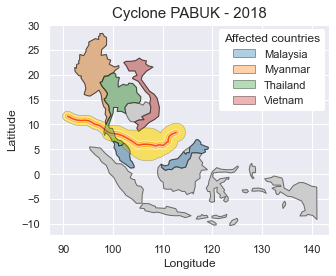

In [560]:
plot_cyclone_on_partial_worldmap4(max_34_shape, max_50_shape, max_64_shape)

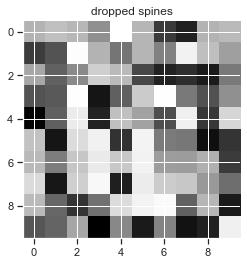

In [563]:
import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)

fig, ax = plt.subplots()

image = np.random.uniform(size=(10, 10))
ax.imshow(image, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('dropped spines')

# Move left and bottom spines outward by 10 points
ax.spines['left'].set_position(('outward', 0))
ax.spines['bottom'].set_position(('outward', 0))
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.show()

In [518]:
def plot_affected_areas_on_partial_worldmap(gdf1):
    sns.set_style('darkgrid')
    sns.set_context('notebook')
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    
    max_34_countries = get_countries(gpd.overlay(world, gdf1, how='intersection'))
    #max_50_countries = get_countries(gpd.overlay(world, gdf2, how='intersection'))
    #max_64_countries = get_countries(gpd.overlay(world, gdf3, how='intersection'))
    #affected_countries = max_34_countries
    
    # defininig the boundaries of the plot
    gdf = gpd.GeoDataFrame(pd.concat([gdf1, gdf2, gdf3]))
    xmin, ymin, xmax, ymax = gdf.total_bounds
    partial_world= world.cx[xmin:xmax, ymin:ymax]
 
    #fig, ax = plt.subplots(figsize=(10, 5))
    fig, ax = plt.subplots()
    partial_world.plot(ax=ax, color=country_general, edgecolor = country_borders, linewidth = linewidth)
   
    # plotting cyclone shapes
    gdf1.plot(ax=ax, markersize=1,  edgecolor='red', linewidth = linewidth, 
              #hatch = '/',
              linestyle= '--',
              color='none', alpha=alpha, label='max_34kn', categorical=True, legend=True)
    
    affected_countries.plot(column='name', categorical=True, ax=ax,label=affected_countries['name'], 
                            legend=True,
                            legend_kwds={'title': 'Affected areas of:', 'edgecolor': 'white', 'facecolor': 'white'})
    palette = dict(zip(sorted(affected_countries['name'].unique()),[cm.tab10(x) for x in range(affected_countries['name'].nunique())]))
    
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    ax.set_title(f"Cyclone {cyclone_name} - {cyclone_year} - max_34kn", fontsize=15)
    #plt.tight_layout(pad=0.05)
    plt.show()

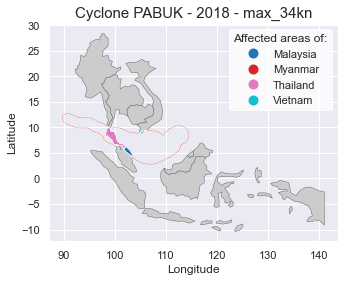

In [519]:
plot_affected_areas_on_partial_worldmap(max_34_shape)

In [ ]:
## Code found here: https://stackoverflow.com/questions/53142563/coloring-specific-countries-with-geopandas

import matplotlib.pyplot as plt
import geopandas as gpd
from descartes import PolygonPatch

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

def plotCountryPatch( axes, country_name, fcolor ):
    # plot a country on the provided axes
    nami = world[world.name == country_name]
    namigm = nami.__geo_interface__['features']  # geopandas's geo_interface
    namig0 = {'type': namigm[0]['geometry']['type'], \
              'coordinates': namigm[0]['geometry']['coordinates']}
    axes.add_patch(PolygonPatch( namig0, fc=fcolor, ec="black", alpha=0.85, zorder=2 ))

# plot the whole world
#ax2 = world.plot( figsize=(8,4), edgecolor=u'gray', cmap='Set2' )

# or plot Africa continent
ax2 = world[world.continent == 'Africa'].plot(figsize=(8,8), edgecolor=u'gray', cmap='Pastel1')

# then plot some countries on top
plotCountryPatch(ax2, 'Namibia', 'red')
plotCountryPatch(ax2, 'Libya', 'green')

# the place to plot additional vector data (points, lines)

plt.ylabel('Latitude')
plt.xlabel('Longitude')

#ax2.axis('scaled')
plt.show()

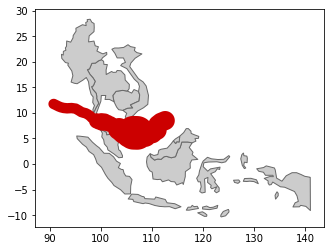

In [99]:
plot_cyclone_on_partial_worldmap(max_34_shape)

In [ ]:
plot_cyclone_on_partial_worldmap(max_50_shape)

In [ ]:
plot_cyclone_on_partial_worldmap(max_64_shape)

In [ ]:
ax = max_34_shape.plot(color='red')

In [ ]:
import pandas as pd
import geopandas as gpd

#linewidth=0.25, edgecolor='white', color='lightgrey'

gdf1 = max_34_shape
gdf2 = max_50_shape
gdf3 = max_64_shape

#gdf = gpd.GeoDataFrame(pd.concat([gdf1, gdf2, gdf3]))
gdf = gpd.GeoDataFrame(pd.concat([gdf1, gdf2, gdf3]))
#plot_cyclone_on_partial_worldmap(gdf)
#gdf.plot(linewidth=0.25, edgecolor='white', color='lightgrey')
ax = gdf.plot(figsize=(20,5), linewidth=0.25, edgecolor='white', color='lightgrey')

In [ ]:
gdf.head(10)

In [55]:
def get_buffered_shape(gdf, windspeed):
    buffer_gdf = bufer_max_output(gdf,windspeed)
    buffered_shape = create_buffered_shape(buffer_gdf, windspeed)
    return buffered_shape

In [56]:
shape = get_buffered_shape(cyclone_gdf, 'max_34')
shape.crs = 'epsg:4326'
shape

,geometry
0,"POLYGON ((111.64966 4.78152, 111.64240 4.77337..."


## Overlaying the shape of the cyclone with the shapes of the worlds
### Determine the affected countries for a cyclone depending on the windspeed shape

In [57]:
affected_countries = gpd.overlay(world, shape, how='intersection')
affected_countries

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,68414135,Asia,Thailand,THA,1161000.0,"POLYGON ((99.15727 9.92613, 99.22240 9.23926, ..."
1,55123814,Asia,Myanmar,MMR,311100.0,"POLYGON ((98.63866 10.11344, 98.55355 9.93296,..."
2,96160163,Asia,Vietnam,VNM,594900.0,"POLYGON ((106.22893 9.39927, 105.15826 8.59976..."
3,31381992,Asia,Malaysia,MYS,863000.0,"MULTIPOLYGON (((101.68921 5.78818, 101.81428 5..."


### Get the affected population

In [58]:
def get_population_by_windspeed(cyclone_name, cyclone_year, affected_countries, windspeed):
    stats = ['sum']
    raster_file = rasterio.open('C:/Users/iDIGITAL/Desktop/image.tif')
    cyclone_data = []
    for i in range (len(affected_countries)):   
        cyclone = {}
        country = affected_countries.iloc[i]['name']
        iso = affected_countries.iloc[i]['iso_a3']
        population = zonal_stats(affected_countries.iloc[i].geometry, input_raster_file, stats = stats)[0]['sum']
        cyclone['NAME'] = cyclone_name
        cyclone['SEASON'] = cyclone_year
        cyclone['COUNTRY'] = country
        cyclone['iso_a3'] = iso
        cyclone['pop_{}'.format(windspeed)] = population   
        cyclone_data.append(cyclone)
    return cyclone_data, raster_file

In [59]:
cyclone_data_windspeed, raster_year = get_population_by_windspeed(cyclone_name, cyclone_year, affected_countries, windspeed)
cyclone_data_windspeed

RasterioIOError: C:/Users/iDIGITAL/Desktop/image.tif: No such file or directory

In [60]:
def get_population_by_windspeed_SID(SID, affected_countries, windspeed):
    
    cyclone_name, cyclone_year = get_cyclone_name_year_by_SID(SID)
    
    stats = ['sum']
    raster_file = select_raster_file(cyclone_year, input_file)
    cyclone_data = []
    for i in range (len(affected_countries)):   
        cyclone = {}
        country = affected_countries.iloc[i]['name']
        iso = affected_countries.iloc[i]['iso_a3']
        population = zonal_stats(affected_countries.iloc[i].geometry, input_raster_file, stats = stats)[0]['sum']
        cyclone['SID']= SID
        cyclone['NAME'] = cyclone_name
        cyclone['SEASON'] = cyclone_year
        cyclone['COUNTRY'] = country
        cyclone['iso_a3'] = iso
        cyclone['pop_{}'.format(windspeed)] = population   
        cyclone_data.append(cyclone)
    return cyclone_data, raster_file

In [61]:
cyclone_data_windspeed, raster_year = get_population_by_windspeed_SID(SID, affected_countries, windspeed)
cyclone_data_windspeed

NameError: name 'select_raster_file' is not defined

### Check if we are using the correct raster file

In [ ]:
raster_year

In [ ]:
# Combining the different outputs into a single dataframe
cyclone_pop_df = pd.DataFrame(cyclone_data_windspeed)
data = cyclone_pop_df.groupby(['SID','NAME','SEASON', 'COUNTRY'], as_index = False).sum()
data

## Summary of the code above for a single cyclone and a single windspeed

In [ ]:
SID = '2019068S17040'
windspeed = 'max_34'
#windspeed = 'max_50'
#windspeed = 'max_64'
cyclone_df = df_input[(df_input.SID == SID)].copy()
single_cyclone_df= create_shifted_dataset(cyclone_df)
cyclone_gdf = create_cyclone_gdf(single_cyclone_df)
shape = get_buffered_shape(cyclone_gdf, windspeed)
shape.crs = 'epsg:4326'
affected_countries = gpd.overlay(world, shape, how='intersection')
cyclone_data_windspeed, raster_year = get_population_by_windspeed_SID(SID, affected_countries, windspeed)
cyclone_data_windspeed

### Creating a function to get all the information for a single cyclone

In [53]:
def get_population_by_cyclone(cylone_name, cyclone_year):    
    single_cyclone_data = []
    cyclone_df = df_input[(df_input.SEASON==cyclone_year) & (df_input.NAME == cyclone_name)].copy()
    single_cyclone_df= create_shifted_dataset(cyclone_df)
    cyclone_gdf = create_cyclone_gdf(single_cyclone_df)
    for windspeed in windspeeds:
        shape = get_buffered_shape(cyclone_gdf, windspeed)
        shape.crs = 'epsg:4326'
        affected_countries = gpd.overlay(world, shape, how='intersection')
        cyclone_data_windspeed, raster_year = get_population_by_windspeed(cyclone_name, cyclone_year,affected_countries, windspeed)
        single_cyclone_data.extend(cyclone_data_windspeed)
        print(cyclone_data_windspeed)
    return single_cyclone_data, raster_year

In [54]:
cyclone_year = 1950
cyclone_name = 'JANE'
example_pop, raster_year = get_population_by_cyclone(cyclone_name, cyclone_year)
print(raster_year)
print(example_pop)

NameError: name 'get_buffered_shape' is not defined

In [ ]:
def get_population_by_SID(SID):    
    single_cyclone_data = []
    cyclone_df = df_input[(df_input.SID==SID)].copy()
    single_cyclone_df= create_shifted_dataset(cyclone_df)
    cyclone_gdf = create_cyclone_gdf(single_cyclone_df)
    for windspeed in windspeeds:
        shape = get_buffered_shape(cyclone_gdf, windspeed)
        shape.crs = 'epsg:4326'
        affected_countries = gpd.overlay(world, shape, how='intersection')
        cyclone_data_windspeed, raster_year = get_population_by_windspeed_SID(SID,affected_countries, windspeed)
        single_cyclone_data.extend(cyclone_data_windspeed)
        print(cyclone_data_windspeed)
    return single_cyclone_data, raster_year

In [ ]:
SID = '1949163N07145'
example_pop, raster_year = get_population_by_SID(SID)
print(raster_year)
print(example_pop)

## Creating population data for all cyclones by SID

In [ ]:
cyclone_data = []
error_cyclone = []
#for i in range (10):                  
for i in range (len(cyclones)):             ## Change here to get output for all cyclones
    cyclone = {}
    cyclone_SID = (cyclones.iloc[i]['SID'])
    cyclone_name = (cyclones.iloc[i]['NAME'])
    cyclone_year = (cyclones.iloc[i]['SEASON'])
    print(f'{i}/{len(cyclones)} Getting population for:{cyclone_SID}-{cyclone_name}-{cyclone_year}')
    try:
        cyclone_population, raster_year = get_population_by_SID(cyclone_SID)
        cyclone_data.extend(cyclone_population)
        print(f'Rasterfile: {raster_year}')
        print('--------------------------------------------')
    except:
        print(f'Error for cyclone {cyclone_name} - {cyclone_year}')
        error_cyclone.append((cyclone_name, cyclone_year))
cyclone_pop = pd.DataFrame(cyclone_data)
summary_df = cyclone_pop.groupby(['SID','NAME','SEASON', 'COUNTRY'], as_index = False).sum()

In [ ]:
summary_df

In [ ]:
summary_df.to_pickle("../data/population_by_cyclone_sm_v3.pkl")

## Check cyclones that caused geometric errors

In [ ]:
error_cyclone

### Saving the dataframe

In [ ]:
unpickled = pd.read_pickle("../data/population_by_cyclone_sm_v3.pkl")
unpickled

In [ ]:
unpickled.to_csv("../data/population_by_cyclone_sm_v3.csv")

## Creating population data for all cyclones (old version)

In [ ]:
cyclone_data = []
error_cyclone = []
for i in range (10):                  
#for i in range (len(cyclones)):             ## Change here to get output for all cyclones
    cyclone = {}
    cyclone_name = (cyclones.iloc[i]['name'])
    cyclone_year = (cyclones.iloc[i]['year'])
    print(f'{i}/{len(cyclones)} Getting population for {cyclone_name} - {cyclone_year}')
    try:
        cyclone_population, raster_year = get_population_by_cyclone(cyclone_name, cyclone_year)
        cyclone_data.extend(cyclone_population)
        print(f'Rasterfile: {raster_year}')
        print('--------------------------------------------')
    except:
        print(f'Error for cyclone {cyclone_name} - {cyclone_year}')
        error_cyclone.append((cyclone_name, cyclone_year))
cyclone_pop = pd.DataFrame(cyclone_data)
summary_df = cyclone_pop.groupby(['name','year', 'country'], as_index = False).sum()
summary_df